## We Rate Dogs 
### Introduction

This project is part of Udaciy Data Wrangling and Visulization project. I use Python and its libraries to gather data from a variety of sources to analyze and visulize the tweet archive of Twitter user @dog_rates, also known as WeRateDogs, which is a Twitter account that rates people's dogs with a humorous comment about the dog. The data comes in a variety of formats, I assess its quality and tidiness, then clean it to analyze and visulize the key findings.

### The Data Wrangling Process
**Gather**.Data is gathered from three sources

- Enhanced Twitter Archive: This is a csv file provided by Udacity. The archive contains each tweet's text, which Udacity used to enhance by extracting rating, dog name, and dog 'stage' (doggo, floofer, pupper, and puppo).
- Image Predictions File: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). The Requests library is used to downloaded the file programmatically from Udcity's servers.
- Additional Data via the Twitter API,including twitter ID, retweet count and favorite count. I use the requests library to download the json.txt file provided by Udacity its servers.

**Assess**. Data is inspected for quality (content) issues and tidiness (structural)issues. 
- Low quality (‘dirty’) data has content issues such as missing, invalid, inaccurate, and inconsistent data. I assessed removing unnecessary columns, converting data types, making dog names title case, removing entries that were not really dogs.
- Untidy (‘messy’) data has structural issues. I assessed gathering dog stages from multiple columns into one, and combining the three datasets into one.

**Clean**. I first addressed missing data, then structural issues, then quality issues. 

For this project, we only want original ratings (no retweets) that have images.The requirements of this project are to assess and clean at least 8 quality and 2 tidiness issues in this dataset.Cleaning includes removing missing value, creating new columns, merging individual pieces of data.





In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tweepy
import time
import datetime as dt
%matplotlib inline

**Gather**

a. Read in csv file as pandas dataframe and quick check to view structure

In [4]:
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv")
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


b. Use Requests library to programmatically download tsv file from a website and view structure

In [17]:

# import tweet image   
import requests
url1 = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

response = requests.get(url1, allow_redirects=True)
open('tweet_json.txt', 'wb').write(response.content)

#the data is store in the computer response library, we can access the data with .content
#save html to file
with open("image_predictions.tsv", 'wb') as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(response.content)
#open the file        
image_predictions = pd.read_csv("image_predictions.tsv", sep= "\t")

# view structure
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


c. Use Requests library to programmatically download json file from the services

In [18]:
url1 = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'

r = requests.get(url1, allow_redirects=True)
open('tweet-json.txt', 'wb').write(r.content)

tweets_data = []
tweets_file = open('tweet-json.txt', "r")
for line in tweets_file:
    try:
        tweet= json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

d. Create dataframe, extract "tweet_id", "retweet_count", "favorite_count", populate the data, and view structure.

In [19]:
tweet_json = pd.DataFrame()
tweet_json['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweet_json['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweet_json['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

tweet_json.head()


,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


**Access**

Dataframe Summary:
- twitter_achieve
- image_predictions
- tweet_json

e. Find out the size of each data set

In [20]:
print('  archive tweet count = ' + str(len(twitter_archive)))
print('   images tweet count = ' + str(len(image_predictions)))
print('tweet_json tweet count = ' + str(len(tweet_json)))

  archive tweet count = 2356
   images tweet count = 5434967
tweet_json tweet count = 2354


f. Access the structure of each data set

In [21]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
image_predictions.describe()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,5434967,5434967,5434967,5434967,5434967,5434967,5434967,5434967,5434967,5434967,5434967,5434967
unique,2076,2010,5,379,2007,3,406,2005,3,409,2007,3
top,679462823135686656,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,golden_retriever,0.806757,True,Labrador_retriever,0.0693617,True,Labrador_retriever,0.0461082,True
freq,2618,5236,4660040,392700,5236,4010776,272272,7854,4065754,206822,5236,3924382


In [23]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


***twitter achieve***

In [24]:
twitter_archive.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
19        Canela
20        Gerald
21       Jeffrey
22          such
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
          ...   
2326       quite
2327           a
2328        None
2329        None
2330        None
2331        None
2332        None
2333          an
2334           a
2335          an
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345         the
2346         the
2347           a
2348           a
2349          an
2350           a
2351        None
2352           a
2353          

In [25]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [26]:
twitter_archive[twitter_archive["expanded_urls"].duplicated()].count()

tweet_id                      137
in_reply_to_status_id          54
in_reply_to_user_id            54
timestamp                     137
source                        137
text                          137
retweeted_status_id             1
retweeted_status_user_id        1
retweeted_status_timestamp      1
expanded_urls                  79
rating_numerator              137
rating_denominator            137
name                          137
doggo                         137
floofer                       137
pupper                        137
puppo                         137
dtype: int64

In [27]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [28]:
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

**Key Findings**

tweet_json has 2354 entries, which is the smallest among the three datasets.Image_predictions has over 50k entries. 
- The following columns of tweet_achieve have missing data: in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id and retweeted_status_timestamp.
- Some columns have wrong data type, such as timestamp,rating_numerator, id. The rating numerator is in an integer in the dataset, it should be a float, also some of the text shows the ratting are decimals.
- The text and url columns have cut off, need to adjust the column width to fit the text.
- The dog stages are in different columns, should be groupped into one column
- There are missing value in name columns of twitter_achieve file. Not all entries appear to be the correct names nor are they in title case, will clean after merging the datasets
- The data source columns of image_prediction file shows the url link and link text, which is hard to read and need to tidy the data in a readable way.
- The rating denominator should have number of 10, but there are some outliers since the max is 170
- The interquartile range of the numerator rating is between 10 and 12. Since the max is 1776 there are likely outliers.
- 137 twitter id have duplicated expanded urls

***Image Predictions***

In [29]:
list(image_predictions[image_predictions.jpg_url.duplicated()].tweet_id)

['752309394570878976',
 '754874841593970688',
 '757729163776290825',
 '759159934323924993',
 '759566828574212096',
 '761371037149827077',
 '761750502866649088',
 '766078092750233600',
 '770093767776997377',
 '771171053431250945',
 '772615324260794368',
 '775898661951791106',
 '776819012571455488',
 '777641927919427584',
 '778396591732486144',
 '780496263422808064',
 '782021823840026624',
 '783347506784731136',
 '786036967502913536',
 '788070120937619456',
 '790723298204217344',
 '791026214425268224',
 '793614319594401792',
 '794355576146903043',
 '794983741416415232',
 '796177847564038144',
 '798340744599797760',
 '798628517273620480',
 '798644042770751489',
 '798665375516884993',
 '798673117451325440',
 '798694562394996736',
 '798697898615730177',
 '799774291445383169',
 '800443802682937345',
 '802247111496568832',
 '802624713319034886',
 '803692223237865472',
 '804413760345620481',
 '805958939288408065',
 '806242860592926720',
 '807059379405148160',
 '808134635716833280',
 '809808892

In [30]:
image_predictions[image_predictions.jpg_url.duplicated()].count()

tweet_id    5432957
jpg_url     5432957
img_num     5432957
p1          5432957
p1_conf     5432957
p1_dog      5432957
p2          5432957
p2_conf     5432957
p2_dog      5432957
p3          5432957
p3_conf     5432957
p3_dog      5432957
dtype: int64

In [31]:
len(image_predictions) - len(image_predictions[(image_predictions['p1_dog']== True) | (image_predictions['p2_dog'] == True) | (image_predictions['p3_dog'] == True)])

5434967

In [32]:
str(image_predictions.p1.nunique()),str(image_predictions.p2.nunique()), str(image_predictions.p3.nunique())

('379', '406', '409')

In [33]:
image_predictions.jpg_url.nunique(), image_predictions.tweet_id.nunique()

(2010, 2076)

**Key Findings**
- The image prediction have 5432957 duplicated value
- p1 has 379 unique number,p2 has 406 unique number and p3 has 409 unique number
- There are 2076 unique id, but only has 2010 unique image url, which means some tweet id has the same image

** Assessment Observations**

Low quality, also known as dirty, data has content issues such as missing, invalid, inaccurate, and inconsistent
data. Untidy, also known as messy, data has structural issues: each variable should form a column, each
observation should form a row, and each observational unit a table. Assessment observations are not action
items; actions items will be defined when cleaning.

Quality
- There are some unnecessary columns
- The retweets rows need to be removed
- Need to convert timestamp to datetime object
- Need to convert ratings to float and fix rating issue that are not extracted properly, some should be decimals
- Need to update source columns from url to text format
- Make ratings_denominator "10" for consistency and remove outliers
- convert non-dog names to "None" and set p1,p2,p3 to title case
- Convert tweet_id datatype to string object

Tidiness
- Combined dog stages to one column call "dog stage" and remove individual stage columns
- Join three dataset to one master dataset on "twitter_id"

**Clean**
- A copy of original dataset will be created for data analysis
- The 3 copied dataset will be merged into one master table for visualization
- During the data cleaning process, I first remove the missing and duplicated data, next is to address quality and tidiness issue

In [35]:
# Create copies of original dataframes
twitter_clean = twitter_archive.copy()
images_clean = image_predictions.copy()
tweet_clean = tweet_json.copy()

In [36]:
#check if the dataset copy have the same number of entries
len(tweet_clean), len(twitter_clean), len(images_clean)

(2354, 2356, 5434967)

In [37]:
#excluding retweeted status because they are not needed
twitter_clean = twitter_clean[pd.isnull(twitter_clean.retweeted_status_id)]
twitter_clean = twitter_clean.drop_duplicates()
#Removinge rows where there are no images (expanded_urls).
twitter_clean = twitter_clean.dropna(subset=['expanded_urls'])

In [38]:
pd.set_option('display.max_colwidth', -1)


In [ ]:
#create 'dog_stage"
twitter_clean["dog_stage"] = twitter_clean.text.str.extract('(puppo|pupper|floofer|doggo)', expand=True)

In [39]:
columns = ['doggo', 'floofer', 'pupper', 'puppo']
twitter_clean.drop(columns, axis=1,inplace = True)

In [40]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 231.5+ KB


In [41]:
twitter_clean.drop(columns = ["in_reply_to_status_id", 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],inplace = True)



In [42]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
dtypes: int64(3), object(5)
memory usage: 148.9+ KB


In [43]:
# delete duplicated jpg_url
images_clean = images_clean.drop_duplicates(subset = ["jpg_url"], keep = "last")

In [44]:
images_clean['p1'] = images_clean['p1'].str.title()
images_clean['p2'] = images_clean['p2'].str.title()
images_clean['p3'] = images_clean['p3'].str.title()

In [45]:
not_named_to_replace = twitter_clean.loc[(twitter_clean['name'].str.islower())]

In [46]:
not_named_to_replace_list = not_named_to_replace['text'].tolist()

In [47]:
for entry in not_named_to_replace_list:
    mask = twitter_clean.text == entry
    name_column = 'name'
    twitter_clean.loc[mask, name_column] = "None"

In [48]:

twitter_clean.loc[(twitter_clean['name'].str.islower())]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name


In [49]:
#change data type to the correct type
twitter_clean["timestamp"] = pd.to_datetime(twitter_clean['timestamp'])

In [50]:
twitter_clean["tweet_id"] = twitter_clean["tweet_id"].astype('str')

In [51]:
images_clean["tweet_id"] = images_clean["tweet_id"].astype('str')

In [52]:
tweet_clean["tweet_id"] = tweet_clean["tweet_id"].astype('str')

In [53]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [54]:
twitter_clean = pd.merge(left=twitter_clean, right=tweet_clean, left_on='tweet_id', right_on='tweet_id', how='inner')
twitter_clean = twitter_clean.merge(images_clean, on='tweet_id', how='inner')

In [55]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 21 columns):
tweet_id              1928 non-null object
timestamp             1928 non-null datetime64[ns]
source                1928 non-null object
text                  1928 non-null object
expanded_urls         1928 non-null object
rating_numerator      1928 non-null int64
rating_denominator    1928 non-null int64
name                  1928 non-null object
retweet_count         1928 non-null int64
favorite_count        1928 non-null int64
jpg_url               1928 non-null object
img_num               1928 non-null object
p1                    1928 non-null object
p1_conf               1928 non-null object
p1_dog                1928 non-null object
p2                    1928 non-null object
p2_conf               1928 non-null object
p2_dog                1928 non-null object
p3                    1928 non-null object
p3_conf               1928 non-null object
p3_dog                1928 no

In [56]:
twitter_clean['name'] = twitter_clean['name'].replace('None', np.NaN)

In [57]:
twitter_clean[twitter_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
38,883482846933004288,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,10407,46860,...,1,Golden_Retriever,0.943082,True,Labrador_Retriever,0.032409,True,Kuvasz,0.00550072,True
478,786709082849828864,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,7069,20296,...,1,Pomeranian,0.467321,True,Persian_Cat,0.122978,False,Chow,0.102654,True
521,778027034220126208,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,1885,7320,...,1,Clumber,0.9467180000000001,True,Cocker_Spaniel,0.0159499,True,Lhasa,0.00651911,True
1319,680494726643068929,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,NaN,542,1879,...,1,Kuvasz,0.43862700000000004,True,Samoyed,0.111622,True,Great_Pyrenees,0.0640608,True


In [60]:
# Remove url from sources
twitter_clean['source'] = twitter_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
twitter_clean['source'] = twitter_clean['source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine')
twitter_clean['source'] = twitter_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_clean['source'] = twitter_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

In [61]:

# Change datatype to category
twitter_clean['source'] = twitter_clean['source'].astype('category')

In [62]:
twitter_clean.source.value_counts()

Twitter for iPhone    1891
Twitter Web Client    26  
TweetDeck             11  
Name: source, dtype: int64

In [67]:
twitter_clean['dog_stage'] = twitter_clean['dog_stage'].astype('category')

In [68]:

twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 1927
Data columns (total 22 columns):
tweet_id              1928 non-null object
timestamp             1928 non-null datetime64[ns]
source                1928 non-null category
text                  1928 non-null object
expanded_urls         1928 non-null object
rating_numerator      1928 non-null int64
rating_denominator    1928 non-null int64
name                  1303 non-null object
retweet_count         1928 non-null int64
favorite_count        1928 non-null int64
jpg_url               1928 non-null object
img_num               1928 non-null object
p1                    1928 non-null object
p1_conf               1928 non-null object
p1_dog                1928 non-null object
p2                    1928 non-null object
p2_conf               1928 non-null object
p2_dog                1928 non-null object
p3                    1928 non-null object
p3_conf               1928 non-null object
p3_dog                1928 

In [69]:
twitter_clean.to_csv('twitter_archive_master.csv')


### Analysis & Visualizations



a. How's the distribution of the rating_numerator? 

In [70]:
len(twitter_archive[twitter_archive.rating_numerator > 15])

26

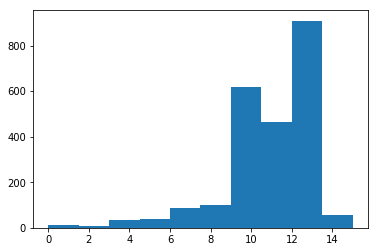

In [85]:
plot = plt.hist(twitter_archive.rating_numerator.sort_values()[0:2330]);
plot;

**Key Findings:**
There are 26 ratings greater than 15. Majority of the ratting are range between 10 to 13, with 13 received the most rattings.

In [92]:
plt.savefig('rating_numerator_plot.png')

b. How's the distribution of the favories count and retreet count? 

In [73]:
df = twitter_clean[['retweet_count', 'favorite_count', 'dog_stage']]

In [74]:
df_puppers = df[df['dog_stage'] == 'pupper']
df_puppo = df[df['dog_stage'] == 'puppo']
df_doggo = df[df['dog_stage'] == 'doggo']
df_floofer = df[df['dog_stage'] == 'floofer']
df_none = df[df['dog_stage'] == 'None']

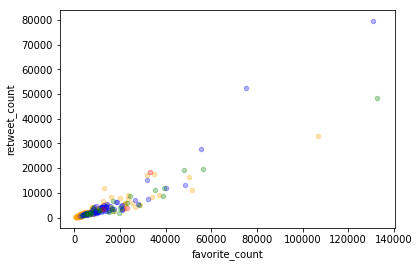

In [76]:
# Plot all data to see general shape
bx = df_puppers.plot(kind = 'scatter', x='favorite_count', y='retweet_count', color='Orange', alpha=0.3)
df_doggo.plot(kind = 'scatter', x='favorite_count', y='retweet_count', color='Blue', ax=bx, alpha=0.3)
df_puppo.plot(kind = 'scatter', x='favorite_count', y='retweet_count', color='Green', ax=bx, alpha=0.3)
df_floofer.plot(kind = 'scatter', x='favorite_count', y='retweet_count', color='Red', ax=bx, alpha=0.3);

** Key Findings**
The chart shows there are direct relationship between retweet_count and favorite_count. The more favorite the dog received, the more retweet will happen. Most of the images have less than 20000 favories.

c. How's the retweet and favorite changed over time?

In [78]:
time_df = twitter_clean[['timestamp', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator']].copy()

In [79]:

# Set the index to be the timestamp so time is displayed properly in plots
time_df.set_index('timestamp', inplace=True)

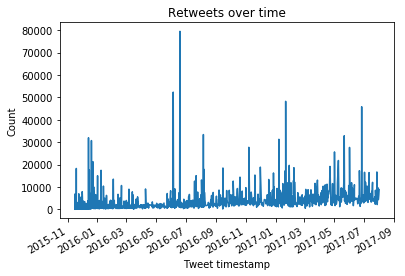

In [80]:
time_df['retweet_count'].plot()
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets over time');

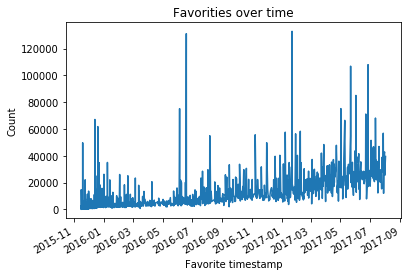

In [81]:
time_df['favorite_count'].plot()
plt.xlabel('Favorite timestamp')
plt.ylabel('Count')
plt.title('Favorities over time');

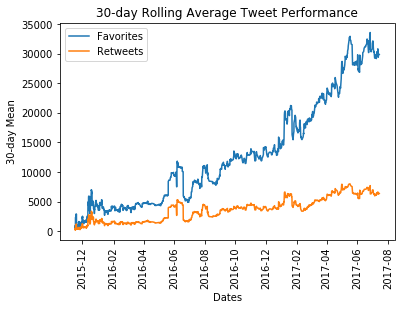

In [82]:
%matplotlib inline
# Creating column of a rolling 30-day average for favorites and retweets
twitter_clean['rolling_favorite'] = twitter_clean.favorite_count.rolling(window = 30).mean()
twitter_clean['rolling_retweet'] = twitter_clean.retweet_count.rolling(window = 30).mean()

# Plotting the 30-day average on favorites and retweets.
plt.plot(twitter_clean.timestamp, twitter_clean.rolling_favorite, label = 'Favorites')
plt.plot(twitter_clean.timestamp, twitter_clean.rolling_retweet, label = 'Retweets')
plt.title('30-day Rolling Average Tweet Performance')
plt.xlabel('Dates')
plt.ylabel('30-day Mean')
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show();

**Key Findings**
Both Favorities and Retweets saw increase over time. There are a spike in both favories and retweet in June 2016. The favories count increase rate is bigger than retweets.

d. How are the different dog stages?

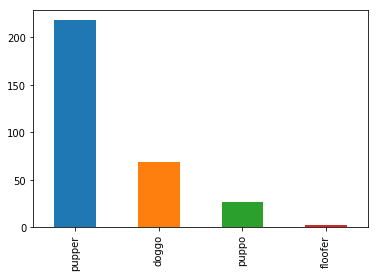

In [83]:
twitter_clean['dog_stage'].value_counts().plot(kind='bar');
                                     

**Key Findings**
Pupper is the most popular dog, followed by doggo, with floofer being the least

**References:**
1.https://static1.squarespace.com/static/55bfa8e4e4b007976149574e/t/5b870d818a922de25747cbdc/1535577475794/wrangle_act.pdf
2. http://www.karenbevis.com/weratedogs/
3. https://ryanwingate.com/projects/3/

